In [6]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
from scipy import stats as scipy_stats
import scipy.signal
import rasterio
import rasterio.features
from rasterio import MemoryFile
from affine import Affine
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import rasterstats
from shapely.geometry import Polygon, MultiPolygon, shape

# Import libs
import sys
module_path = os.path.abspath(os.path.join('..', '..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from s3utils import *

In [7]:
S3R = S3Helper('roof-index')
slope_path = "missoula/geospatial/downtown_slope.tif" 
slope = S3R.read_tif_from_s3_as_rio(slope_path) 
slope_arr = slope.read(1)
affine = slope.transform

bldgs_path = "missoula/geospatial/downtown_flat_beta.zip"
bldgs = S3R.read_shp_from_s3_as_gpd(bldgs_path).to_crs(6514)
bldgs = bldgs[bldgs['flat'] == 1]

## Make a new GDF that is a ring around the outer meter of the building (theoretically where the parapet would be)

In [10]:
def make_parapet_polygon(bldgs):
    
    """
    bldgs: gpd dataframe of building footprints.
    """

    # Make gdf that is a boundary of the building
    bounds = bldgs['geometry']
    bounds = gpd.GeoDataFrame({'geometry': bounds, 'fid': bldgs['fid']})

    # Make gdf that is a 1m buffer around the inside of the building.
    buff = bldgs['geometry'].buffer(-1)
    buff = gpd.GeoDataFrame({'geometry': buff, 'fid': bldgs['fid']})

    # Join the two gdfs to make a ring polygon around the edge of the building
    parapet = gpd.overlay(bounds, buff, how='difference')
    parapet['area'] = parapet['geometry'].area
    
    return parapet

## Calculate the median slope of the outer edge of the building

<AxesSubplot:>

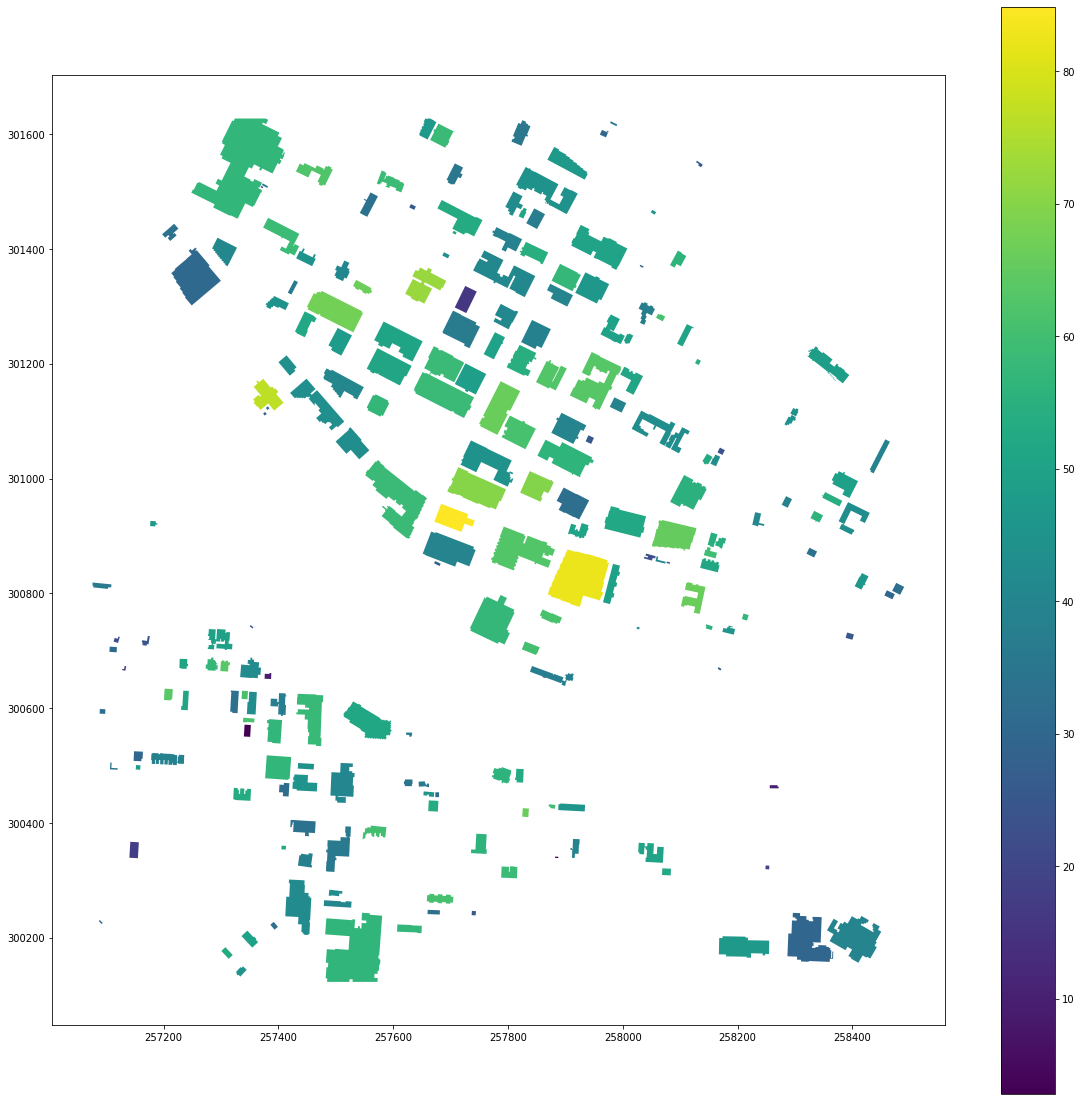

In [13]:
# Function to add median slope values to each polygon
def add_stats(shp, ras, col_name):
    zstats = rasterstats.zonal_stats(shp, ras.read(1), affine=ras.transform,
    nodata=ras.nodata, geojson_out=True, stats="median")

    stat = []
    for b in zstats:
        temp = (b['properties']['fid'], b['properties']['median'])
        stat.append(temp)

    df = gpd.GeoDataFrame(stat, columns=['fid', col_name])
    full_data = pd.merge(shp, df)
    
    return full_data

def calculate_parapet_slopes(bldgs, slope_raster):
    """
    bldgs: gdf of building footprints.
    slope_raster: rio object of slope.
    """
    
    # Add parapet slope to buildings gdf
    parapet = make_parapet_polygon(bldgs)
    parapet = add_stats(parapet, slope_raster, 'parapet_slope')
    bldgs['parapet_slope'] = parapet['parapet_slope'].values
    
    return bldgs

bldgs = calculate_parapet_slopes(bldgs, slope)
fig, ax = plt.subplots(1,1, figsize=(20,20))
bldgs.plot(column='parapet_slope', legend=True, ax=ax)

In [14]:
bldgs.to_file('/Users/colinbrust/Desktop/parapets.shp')

<ipython-input-14-880b5e13cf28>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bldgs.to_file('/Users/colinbrust/Desktop/parapets.shp')
